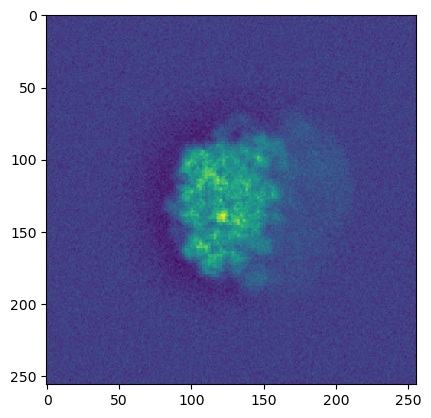

In [3]:
import numpy as np

vol_path = "/root/r2_gaussian/data/synthetic_dataset/parallel_ntrain_75_angle_360/cryo_128_parallel/proj_train/proj_train_0000.npy"

vol = np.load(vol_path)
import matplotlib.pyplot as plt
plt.imshow(vol)
# plot_tomo_slices(vol)
# put_mrc_data(vol,'foot.mrc')

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import fft
"""
Functions for reading and writing common files
"""

import pickle

import mrcfile
import struct
import os
import numpy as np
import sys

def format_png_array(m, normalize=True):
    """
    format a 2D array for png saving
    """
    m = np.array(m, dtype=np.float64)

    mv = m[np.isfinite(m)]
    if normalize:
        # normalize intensity to 0 to 1
        if mv.max() - mv.min() > 0:
            m = (m - mv.min()) / (mv.max() - mv.min())
        else:
            m = np.zeros(m.shape)
    else:
        assert mv.min() >= 0
        assert mv.max() <= 1

    m = np.ceil(m * 65534)
    m = np.array(m, dtype=np.uint16)

    return m

def save_png(m, name, normalize=True, verbose=False):
    if verbose:
        print('save_png()')
        print('unique values', sorted(set(m.flatten())))

    m = format_png_array(m, normalize=normalize)

    import png  # in pypng package
    png.from_array(m, mode='L;16').save(name)


def read_mrc_data(path, show_progress=False):
    mrc = mrcfile.open(path, mode='r+', permissive=True)
    a = mrc.data
    assert a.shape[0] > 0
    a = a.astype(np.float32)
    # a = a.transpose([2, 1, 0])

    return a

def read_mrc(path, read_data=True, show_progress=False):
    path = os.path.realpath(path)
    with open(path, 'rb') as f:
        mrc = {}
        mrc['nx'] = int(struct.unpack('i', f.read(4))[0])
        mrc['ny'] = int(struct.unpack('i', f.read(4))[0])
        mrc['nz'] = int(struct.unpack('i', f.read(4))[0])
        mrc['mode'] = struct.unpack('i', f.read(4))[0]
        mrc['nxstart'] = struct.unpack('i', f.read(4))[0]
        mrc['nystart'] = struct.unpack('i', f.read(4))[0]
        mrc['nzstart'] = struct.unpack('i', f.read(4))[0]
        mrc['mx'] = struct.unpack('i', f.read(4))[0]
        mrc['my'] = struct.unpack('i', f.read(4))[0]
        mrc['mz'] = struct.unpack('i', f.read(4))[0]
        mrc['xlen'] = struct.unpack('f', f.read(4))[0]
        mrc['ylen'] = struct.unpack('f', f.read(4))[0]
        mrc['zlen'] = struct.unpack('f', f.read(4))[0]
        mrc['alpha'] = struct.unpack('f', f.read(4))[0]
        mrc['beta'] = struct.unpack('f', f.read(4))[0]
        mrc['gamma'] = struct.unpack('f', f.read(4))[0]
        mrc['mapc'] = struct.unpack('i', f.read(4))[0]
        mrc['mapr'] = struct.unpack('i', f.read(4))[0]
        mrc['maps'] = struct.unpack('i', f.read(4))[0]
        mrc['amin'] = struct.unpack('f', f.read(4))[0]
        mrc['amax'] = struct.unpack('f', f.read(4))[0]
        mrc['amean'] = struct.unpack('f', f.read(4))[0]
        mrc['ispg'] = struct.unpack('h', f.read(2))[0]
        mrc['nsymbt'] = struct.unpack('h', f.read(2))[0]
        mrc['next'] = struct.unpack('i', f.read(4))[0]
        mrc['creatid'] = struct.unpack('h', f.read(2))[0]
        mrc['unused1'] = struct.unpack(('c' * 30), f.read(30))[0]
        mrc['nint'] = struct.unpack('h', f.read(2))[0]
        mrc['nreal'] = struct.unpack('h', f.read(2))[0]
        mrc['unused2'] = struct.unpack(('c' * 28), f.read(28))[0]
        mrc['idtype'] = struct.unpack('h', f.read(2))[0]
        mrc['lens'] = struct.unpack('h', f.read(2))[0]
        mrc['nd1'] = struct.unpack('h', f.read(2))[0]
        mrc['nd2'] = struct.unpack('h', f.read(2))[0]
        mrc['vd1'] = struct.unpack('h', f.read(2))[0]
        mrc['vd2'] = struct.unpack('h', f.read(2))[0]
        mrc['tiltangles'] = struct.unpack(('f' * 6), f.read((4 * 6)))
        mrc['xorg'] = struct.unpack('f', f.read(4))[0]
        mrc['yorg'] = struct.unpack('f', f.read(4))[0]
        mrc['zorg'] = struct.unpack('f', f.read(4))[0]
        mrc['cmap'] = struct.unpack(('c' * 4), f.read(4))
        mrc['stamp'] = struct.unpack(('c' * 4), f.read(4))
        mrc['rms'] = struct.unpack('f', f.read(4))[0]
        mrc['nlabl'] = struct.unpack('i', f.read(4))[0]
        mrc['labl'] = struct.unpack(('c' * 800), f.read(800))
        size = [mrc['nx'], mrc['ny'], mrc['nz']]
        n_voxel = np.prod(size)
        extended = {}
        extended['magnification'] = [0]
        extended['exp_time'] = [0]
        extended['pixelsize'] = [0]
        extended['defocus'] = [0]
        extended['a_tilt'] = ([0] * mrc['nz'])
        extended['tiltaxis'] = [0]
        if (mrc['next'] != 0):
            nbh = (mrc['next'] / 128)
            if (nbh == 1024):
                for lauf in range(nbh):
                    extended['a_tilt'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['b_tilt'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['x_stage'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['y_stage'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['z_stage'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['x_shift'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['y_shift'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['defocus'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['exp_time'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['mean_int'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['tiltaxis'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['tiltaxis'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['pixelsize'][lauf] = struct.unpack('f', f.read(4))[0]
                    extended['magnification'][lauf] = struct.unpack('f', f.read(4))[0]
                    f.seek(offset=(128 - 52), whence=1)
                else:
                    f.seek(offset=MRC.__next__, whence=1)
        if read_data:
            slice_voxel_num = (mrc['nx'] * mrc['ny'])
            v = None
            for i in range(mrc['nz']):
                if show_progress:
                    print('\r', i, '   ', end=' ')
                    sys.stdout.flush()
                if (mrc['mode'] == 0):
                    if (v is None):
                        v = np.zeros(size, dtype=np.int8)
                    data_read = np.fromfile(f, dtype=np.int8, count=slice_voxel_num)
                elif (mrc['mode'] == 1):
                    if (v is None):
                        v = np.zeros(size, dtype=np.int16)
                    data_read = np.fromfile(f, dtype=np.int16, count=slice_voxel_num)
                elif (mrc['mode'] == 2):
                    if (v is None):
                        v = np.zeros(size, dtype=np.float32)
                    data_read = np.fromfile(f, dtype=np.float32, count=slice_voxel_num)
                else:
                    raise Exception('Sorry, i cannot read this as an MRC-File !!!')
                    data_read = None
                if (data_read.size != slice_voxel_num):
                    import pdb
                    pdb.set_trace()
                v[:, :, i] = np.reshape(data_read, (mrc['nx'], mrc['ny']), order='F')
        else:
            v = None
        h = {}
        h['Voltage'] = None
        h['Cs'] = None
        h['Aperture'] = None
        h['Magnification'] = extended['magnification'][0]
        h['Postmagnification'] = None
        h['Exposuretime'] = extended['exp_time'][0]
        h['Objectpixelsize'] = (extended['pixelsize'][0] * 1000000000.0)
        h['Microscope'] = None
        h['Pixelsize'] = None
        h['CCDArea'] = None
        h['Defocus'] = extended['defocus'][0]
        h['Astigmatism'] = None
        h['AstigmatismAngle'] = None
        h['FocusIncrement'] = None
        h['CountsPerElectron'] = None
        h['Intensity'] = None
        h['EnergySlitwidth'] = None
        h['EnergyOffset'] = None
        h['Tiltangle'] = extended['a_tilt'][:mrc['nz']]
        h['Tiltaxis'] = extended['tiltaxis'][0]
        h['Username'] = None
        h['Date'] = None
        h['Size'] = [mrc['nx'], mrc['ny'], mrc['nz']]
        h['Comment'] = None
        h['Parameter'] = None
        h['Fillup'] = None
        h['Filename'] = path
        h['Marker_X'] = None
        h['Marker_Y'] = None
        h['MRC'] = mrc
    return {'header': h, 'value': v, }


def read_mrc_header(path):
    return read_mrc(path=path, read_data=False)['header']


def get_mrc_voxel_spacing(im):
    """
    Calculate voxel spacing
    from the mrc header obtained from read_mrc_header
    in Angstrom unit
    """
    return im['header']['MRC']['xlen'] / im['header']['MRC']['nx']


def put_mrc(mrc, path, overwrite=False):
    put_mrc_data(mrc, path, overwrite=overwrite)

def write_data(data, path, overwrite=False):
    # only for 3D array
    assert data.ndim == 3
    data = data.astype(np.float32)
    # transpose data according to tomominer.image.vol.eman2_util.em2numpy
    # data = data.transpose([2, 1, 0])
    with mrcfile.new(path, overwrite=overwrite) as m:
        m.set_data(data)

def put_mrc_data(mrc, path, overwrite=False):
    write_data(data=mrc, path=path, overwrite=overwrite)


def pickle_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='iso-8859-1')


def pickle_dump(o, path, protocol=-1):
    with open(path, 'wb') as f:
        pickle.dump(o, f, protocol=protocol)

def fft_3d(tomo, norm="ortho"):
    """
    3D Fourier transform with fftshift.
    """
    fft_dim = (-1, -2, -3)
    return fft.fftshift(fft.fftn(tomo, dim=fft_dim, norm=norm), dim=fft_dim)


def plot_fft_tomo_slices(tomo, domain="image", figsize=(7, 5)):
    # docstring
    """
    Plot central slices of a 3D tomogram in either image or Fourier domain.
    """
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    # plot in image domain
    half = (torch.tensor(tomo.shape) / 2).floor().int()
    if domain == "image":
        ax[1].imshow(tomo[half[0], :, :], cmap="gray")
        ax[2].imshow(tomo[:, half[1], :], cmap="gray")
        ax[3].imshow(tomo[:, :, half[2]], cmap="gray")
    # layout
    ax[0].set_title(f"Central Fourier Slice")
    ax[2].set_title(f"Central {'Fourier' if domain=='fourier' else ''} X-Z Slice")
    ax[3].set_title(f"Central {'Fourier' if domain=='fourier' else ''} Y-Z Slice")
    ax[1].set_title(f"Central {'Fourier' if domain=='fourier' else ''} X-Y Slice")
    density_map = torch.tensor(tomo)
    slice_map = density_map[: ,half[1], :]
    fft_map = torch.fft.fftshift(torch.fft.fft2(slice_map))
    fft_map = torch.log(fft_map.abs() + 1)
    fft_map = fft_map.abs().numpy()
    slice_2d = fft_map
    # Plot the 2D slice
    ax[0].imshow(slice_2d, cmap='viridis')
    for a in ax.flatten():
        a.axis("off")
    fig.tight_layout()
    fig.show()

def plot_tomo_slices(tomo, domain="image", figsize=(7, 5)):
    # docstring
    """
    Plot central slices of a 3D tomogram in either image or Fourier domain.
    """
    fig, ax = plt.subplots(1, 4, figsize=figsize)
    # plot in image domain
    half = (torch.tensor(tomo.shape) / 2).floor().int()
    if domain == "image":
        ax[0].imshow(tomo[half[0], :, :], cmap="gray")
        ax[1].imshow(tomo[:, half[1], :], cmap="gray")
        ax[2].imshow(tomo[:, :, half[2]], cmap="gray")
    # layout
    ax[1].set_title(f"Central {'Fourier' if domain=='fourier' else ''} X-Z Slice")
    ax[2].set_title(f"Central {'Fourier' if domain=='fourier' else ''} Y-Z Slice")
    ax[0].set_title(f"Central {'Fourier' if domain=='fourier' else ''} X-Y Slice")

    for a in ax.flatten():
        a.axis("off")
    fig.tight_layout()
    fig.show()


def plot_fft_slice(density_map):
    slice_index = density_map.shape[1] // 2
    density_map = torch.tensor(density_map)
    # slice_map = density_map[slice_index,:, :]   
    slice_map = density_map[: ,slice_index, :]
    # slice_map = density_map[slice_index,: , :]
    fft_map = torch.fft.fftshift(torch.fft.fft2(slice_map))
    fft_map = torch.log(fft_map.abs() + 1)
    fft_map = fft_map.abs().numpy()
    fig, ax = plt.subplots()
    # Find a slice through the center
    slice_2d = fft_map
    # slice_2d = density_map[slice_index,: , :]
    # slice_2d[200:300,:]=100
    # Plot the 2D slice
    ax.imshow(slice_2d, cmap='viridis')
    ax.axis('off')

    plt.show()
    return fft_map